# Monomodal Affine Registration using Convolutional Neural Networks 

In this notebook a Convolutional Neural Network (CNN) is going to be trained to perform an algorithm called image registration. The image registration algorithm consists in, given a reference image, align another image according to the reference. To align means to find a geometrical transformation which makes the other image more similar with the reference.

The archtecture of the CNN was proposed by SLOAN et al. in 2018 [1] and is focused in register monomodal images.  

In [13]:
from keras.layers import Input, Concatenate, Conv2D, concatenate, Flatten, Dense, Dropout
from keras.models import Model
from keras.models import load_model
from keras.optimizers import Adadelta
from keras.utils import Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os

## Creating some useful functions

We are going to use these functions later in this notebook.

In [3]:
def myshow(img, title=None, margin=0.05, dpi=80, size=(1, 3)):
    nda = sitk.GetArrayViewFromImage(img)
    spacing = img.GetSpacing()
        
    ysize = nda.shape[0]
    xsize = nda.shape[1]
      
    figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi

    fig = plt.figure(title, figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])
    
    extent = (0, xsize*spacing[1], 0, ysize*spacing[0])
    
    t = ax.imshow(nda,
            extent=extent,
            interpolation='hamming',
            cmap='gray',
            origin='lower')
    
    if(title):
        plt.title(title)
        
    plt.show()

    extent = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(title + '.png', bbox_inches=extent)

#This function receives an image (Image class of sitk) and does a transformation that rotates and translates the image
def affine_rotate_translate(image, x_translation, y_translation, degrees):
    center = np.floor(np.array(image.GetSize())/2)
    transform = sitk.Euler2DTransform(center, np.deg2rad(degrees), (x_translation, y_translation))
    
    reference_image = image
    interpolator = sitk.sitkCosineWindowedSinc
    default_value = 0
    rotated_translated_image = sitk.Resample(image, reference_image, transform, interpolator, default_value)
    
    return rotated_translated_image

#This function returns the minimum and maximum of an image object
def get_max_min(image):
    max_min = sitk.MinimumMaximumImageFilter()
    max_min.Execute(image)
    
    max_value = max_min.GetMaximum()
    min_value = max_min.GetMinimum()
    
    return np.array([min_value, max_value])

In [4]:
#This class assists the training in the batch form
class My_Custom_Generator(Sequence) :
  
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return [np.expand_dims(np.array([sitk.GetArrayFromImage(sitk.ReadImage(str(file_name) + '/reference.mha')) 
                     for file_name in batch_x]), axis=3), np.expand_dims(np.array([sitk.GetArrayFromImage(sitk.ReadImage(str(file_name) + 
                     '/moving.mha')) for file_name in batch_x]), axis=3)], np.array(batch_y)

## Knowing the MRI Database

The database used in this project is the OASIS-1: Cross-sectional MRI Data in Young, Middle Aged, Nondemented and Demented Older Adults (https://www.oasis-brains.org/#data). This database is composed of 416 subjects and each of these ones have 3 or 4 images. or 20 of the nondemented subjects, images from a subsequent scan session after a short delay (less than 90 days) are also included as a means of assessing acquisition reliability. For more information see: https://www.oasis-brains.org/files/oasis_cross-sectional_facts.pdf

In [5]:
volume_names = pd.read_csv('Data/oasis_cross-sectional.csv')

volume_names = volume_names.iloc[0:416, :]
volume_names['ID']

0      OAS1_0001_MR1
1      OAS1_0002_MR1
2      OAS1_0003_MR1
3      OAS1_0004_MR1
4      OAS1_0005_MR1
5      OAS1_0006_MR1
6      OAS1_0007_MR1
7      OAS1_0009_MR1
8      OAS1_0010_MR1
9      OAS1_0011_MR1
10     OAS1_0012_MR1
11     OAS1_0013_MR1
12     OAS1_0014_MR1
13     OAS1_0015_MR1
14     OAS1_0016_MR1
15     OAS1_0017_MR1
16     OAS1_0018_MR1
17     OAS1_0019_MR1
18     OAS1_0020_MR1
19     OAS1_0021_MR1
20     OAS1_0022_MR1
21     OAS1_0023_MR1
22     OAS1_0025_MR1
23     OAS1_0026_MR1
24     OAS1_0027_MR1
25     OAS1_0028_MR1
26     OAS1_0029_MR1
27     OAS1_0030_MR1
28     OAS1_0031_MR1
29     OAS1_0032_MR1
           ...      
386    OAS1_0426_MR1
387    OAS1_0428_MR1
388    OAS1_0429_MR1
389    OAS1_0430_MR1
390    OAS1_0431_MR1
391    OAS1_0432_MR1
392    OAS1_0433_MR1
393    OAS1_0434_MR1
394    OAS1_0435_MR1
395    OAS1_0437_MR1
396    OAS1_0438_MR1
397    OAS1_0439_MR1
398    OAS1_0440_MR1
399    OAS1_0441_MR1
400    OAS1_0442_MR1
401    OAS1_0443_MR1
402    OAS1_0

## Creating the Database for Registration

The data used in the training step will be obtained by selecting 121 random slices in each of the 416 volumes and applying a rigid transformation to them, which consists in three degrees of freedom: An translation in X and Y, and a rotation around the center of the image. The selected slice is chosen in order to avoid slices that are composed mostly by air. After that, a Gaussian Noise is added to the trasformed image.

At the end, the dataset is composed by 50336 pairs of image. 30201 will be used for training, 10067 for validation and the rest 10068 for testing.

In [6]:
'''#Selecting 121 slices in each of the 416 volumes, because we want 50'000 pairs Reference and Moving
path_names = [] #save the path of the images
parameters = [] #Saving the parameters of the transformation in a sequence X_translation Y_translation Rotation_degree

for name in volume_names['ID']:
    volume = sitk.ReadImage('Data/Volumes/' + name + '/RAW/' + name + '_mpr-1_anon.hdr', sitk.sitkUInt16)

    for i in range(121):
        print("Volume " + name + ", Slice " + str(i))
        slc = np.random.randint(0, 127)
        reference = volume[:, :, slc]

        #Verifying if the selected slice is primarily composed  by air
        while np.sum(sitk.GetArrayFromImage(reference)) < 1e6:
            slc = np.random.randint(0, 127)
            reference = volume[:, :, slc]
            
        #Applying the transformation
        x = np.random.uniform(-30, 30)
        y = np.random.uniform(-30, 30)
        degrees = np.random.uniform(-15, 15)
        transformed = affine_rotate_translate(reference, x, y, degrees)
        moving = sitk.AdditiveGaussianNoise(transformed, standardDeviation=0.01)
        
        #Saving the Reference, Moving and transformation parameters
        path_folder = "Data/Register_Data_Base/" + name + "/Case_" + str(i)
        if not os.path.exists(path_folder):
            os.makedirs(path_folder)
        
        path_names.append(path_folder)
        reference_path = path_folder + "/reference.mha"
        moving_path = path_folder + "/moving.mha"
        
        sitk.WriteImage(reference, reference_path)
        sitk.WriteImage(moving, moving_path)
        
        #Saving the parameters
        parameters.append([-x, -y, -degrees])
        
parameters_df = pd.DataFrame(data=parameters, index=path_names, columns=['x', 'y', 'degrees'], dtype=np.float64, )
parameters_df.to_csv(os.getcwd() + "/Data/Register_Data_Base/transformation_parameters.csv", encoding='utf-8')'''

'#Selecting 121 slices in each of the 416 volumes, because we want 50\'000 pairs Reference and Moving\npath_names = [] #save the path of the images\nparameters = [] #Saving the parameters of the transformation in a sequence X_translation Y_translation Rotation_degree\n\nfor name in volume_names[\'ID\']:\n    volume = sitk.ReadImage(\'Data/Volumes/\' + name + \'/RAW/\' + name + \'_mpr-1_anon.hdr\', sitk.sitkUInt16)\n\n    for i in range(121):\n        print("Volume " + name + ", Slice " + str(i))\n        slc = np.random.randint(0, 127)\n        reference = volume[:, :, slc]\n\n        #Verifying if the selected slice is primarily composed  by air\n        while np.sum(sitk.GetArrayFromImage(reference)) < 1e6:\n            slc = np.random.randint(0, 127)\n            reference = volume[:, :, slc]\n            \n        #Applying the transformation\n        x = np.random.uniform(-30, 30)\n        y = np.random.uniform(-30, 30)\n        degrees = np.random.uniform(-15, 15)\n        transf

## Creating the Convolutional Neural Network

The CNN archtecture is presented below. It basically consists in two 2D convolutional layers concatenated which selects some features necessary for the registration. After these layers, the output is inserted as input of a series of three dense layers. The output of the whole NN is three parameters, the X, Y for the translation and d degrees for the rotation.

In [7]:
'''#Be careful: Input pixel range - 0 -- 1; concatenation approach, flatten approach
reference_input = Input(shape=(256, 256, 1), name='Reference')
moving_input = Input(shape=(256, 256, 1), name='Moving')

shared_conv1 = Conv2D(1, (3, 3), activation='relu', name='Shared_Conv1')
filtered_reference1 = shared_conv1(reference_input)
filtered_moving1 = shared_conv1(moving_input)

shared_conv2 = Conv2D(1, (3, 3), activation='relu', name='Shared_Conv2')
filtered_reference2 = shared_conv2(filtered_reference1)
filtered_moving2 = shared_conv2(filtered_moving1)

merged_vector = concatenate([filtered_reference2, filtered_moving2], axis=-1)
flatten_layer = Flatten()
flatten_vector = flatten_layer(merged_vector)

drop_layer = Dropout(0.5)
droped_merged_vector = drop_layer(flatten_vector)

densed_output1 = Dense(64, activation='relu', name='Dense_64_1')(droped_merged_vector)
densed_output2 = Dense(64, activation='relu', name='Dense_64_2')(densed_output1)
parameters = Dense(3, activation='linear', name='Dense_3')(densed_output2)

model = Model(inputs=[reference_input, moving_input], outputs=parameters)
model.compile(optimizer=Adadelta(1, 0.95), loss='mean_squared_error')

model.summary()'''

"#Be careful: Input pixel range - 0 -- 1; concatenation approach, flatten approach\nreference_input = Input(shape=(256, 256, 1), name='Reference')\nmoving_input = Input(shape=(256, 256, 1), name='Moving')\n\nshared_conv1 = Conv2D(1, (3, 3), activation='relu', name='Shared_Conv1')\nfiltered_reference1 = shared_conv1(reference_input)\nfiltered_moving1 = shared_conv1(moving_input)\n\nshared_conv2 = Conv2D(1, (3, 3), activation='relu', name='Shared_Conv2')\nfiltered_reference2 = shared_conv2(filtered_reference1)\nfiltered_moving2 = shared_conv2(filtered_moving1)\n\nmerged_vector = concatenate([filtered_reference2, filtered_moving2], axis=-1)\nflatten_layer = Flatten()\nflatten_vector = flatten_layer(merged_vector)\n\ndrop_layer = Dropout(0.5)\ndroped_merged_vector = drop_layer(flatten_vector)\n\ndensed_output1 = Dense(64, activation='relu', name='Dense_64_1')(droped_merged_vector)\ndensed_output2 = Dense(64, activation='relu', name='Dense_64_2')(densed_output1)\nparameters = Dense(3, activ

Because the training set is very large, the training step will be done in batches. So, in order to do that, we create some keras sequences that will feed the CNN with the batches. The validation and test sets will also be inserted in the algorithm in the batch approach due to their sizes.

In [16]:
#Reading the filenames
data_filenames = pd.read_csv('Data/Register_Data_Base/transformation_parameters.csv')

#Percentage of the whole data that corresponds to each set (training, validation and test)
training_rate = 0.6
validation_rate = 0.2
test_rate = 1 - training_rate - validation_rate

training_indice = int(training_rate*data_filenames.shape[0])
validation_rate = int(training_indice + validation_rate*data_filenames.shape[0])
test_rate = int(validation_rate + test_rate*data_filenames.shape[0])

X_train_filenames = data_filenames.iloc[0:training_indice, 0].to_numpy()
y_train = data_filenames.iloc[0:training_indice, 1:].to_numpy()

X_val_filenames = data_filenames.iloc[training_indice:validation_rate, 0].to_numpy()
y_val = data_filenames.iloc[training_indice:validation_rate, 1:].to_numpy()

X_test_filenames = data_filenames.iloc[validation_rate:test_rate, 0].to_numpy()
y_test = data_filenames.iloc[validation_rate:test_rate, 1:].to_numpy()

#Creating the instances for the batch training
batch_size = 32

my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)
my_test_batch_generator = My_Custom_Generator(X_test_filenames, y_test, batch_size)

## Training the CNN

In [9]:
'''hist = model.fit_generator(generator=my_training_batch_generator,
                           steps_per_epoch = int(len(X_train_filenames) // batch_size),
                           epochs = 30,
                           verbose = 1,
                           validation_data = my_validation_batch_generator,
                           validation_steps = int(len(X_val_filenames) // batch_size))'''

'hist = model.fit_generator(generator=my_training_batch_generator,\n                           steps_per_epoch = int(len(X_train_filenames) // batch_size),\n                           epochs = 30,\n                           verbose = 1,\n                           validation_data = my_validation_batch_generator,\n                           validation_steps = int(len(X_val_filenames) // batch_size))'

In [10]:
'''plt.plot(hist.history['loss'], label='Training Error')
plt.plot(hist.history['val_loss'], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('MSE x Epochs')

plt.legend(loc='upper right')
plt.savefig('MSE_Epochs_Evolution.png')'''

"plt.plot(hist.history['loss'], label='Training Error')\nplt.plot(hist.history['val_loss'], label='Validation Error')\nplt.xlabel('Epochs')\nplt.ylabel('MSE')\nplt.title('MSE x Epochs')\n\nplt.legend(loc='upper right')\nplt.savefig('MSE_Epochs_Evolution.png')"

## Saving the Neural Network Architecture and Parameters

In [11]:
#model.save('CNN_2D_Registration_Monomodal_without_padding_intermediate.h5')

## Loading the Model

In [14]:
model = load_model('CNN_2D_Registration_Monomodal_without_padding_intermediate.h5')

## Analyzing the CNN in the Test Data

In [17]:
#Why the NN asks for a 4D image?

#Reading the test examples
test_reference = sitk.ReadImage('Data/Register_Data_Base/OAS1_0368_MR1/Case_96/reference.mha')
test_moving = sitk.ReadImage('Data/Register_Data_Base/OAS1_0368_MR1/Case_96/moving.mha')

test_reference_array = np.expand_dims(np.expand_dims(sitk.GetArrayFromImage(test_reference), axis=3), axis=0)
test_moving_array = np.expand_dims(np.expand_dims(sitk.GetArrayFromImage(test_moving), axis=3), axis=0)

parameters = model.predict(x=my_test_batch_generator)
parameters = parameters.astype('float')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  import sys
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


In [18]:
Error = parameters - y_test
mse = (np.square(Error)).mean()
print('Mean Square Error in the Test Data: ' + str(mse))

Mean Square Error in the Test Data: 3.8896062223192374


In [19]:
X_mean = Error[0].mean()
X_sd = Error[0].std()

Y_mean = Error[1].mean()
Y_sd = Error[1].std()

d_mean = Error[2].mean()
d_sd = Error[2].std()

print('X error: ' + str(X_mean) + ' +- ' + str(X_sd))
print('Y error: ' + str(Y_mean) + ' +- ' + str(Y_sd))
print('d error: ' + str(d_mean) + ' +- ' + str(d_sd))

X error: -1.6941874449292353 +- 1.094936988953735
Y error: -0.4479155264462656 +- 0.5640271960437184
d error: -0.43275475691900667 +- 0.9101407342287605


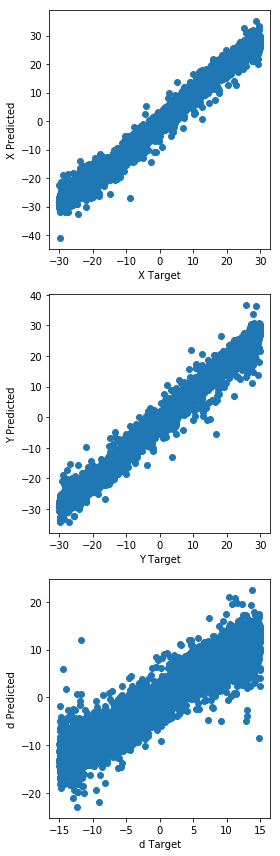

In [20]:
fig, axs = plt.subplots(3, 1, figsize=(4, 12), sharey='none')

axs[0].scatter(y_test[:, 0], parameters[:, 0])
axs[0].set_xlabel('X Target')
axs[0].set_ylabel('X Predicted')

axs[1].scatter(y_test[:, 1], parameters[:, 1])
axs[1].set_ylabel('Y Predicted')
axs[1].set_xlabel('Y Target')

axs[2].scatter(y_test[:, 2], parameters[:, 2])
axs[2].set_xlabel('d Target')
axs[2].set_ylabel('d Predicted')

fig.tight_layout()

fig.savefig('Parameters_distribution.png')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  after removing the cwd from sys.path.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  """


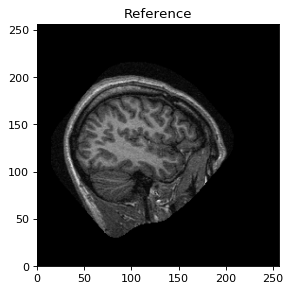

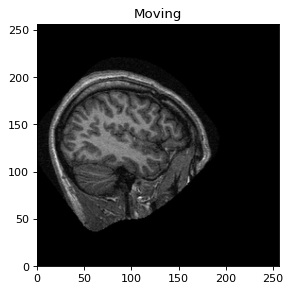

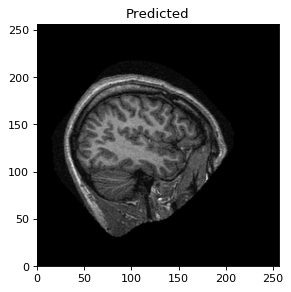

Data/Register_Data_Base/OAS1_0439_MR1/Case_62
Predicted Parameters: [[-16.25903702   1.47265697  -4.86688852]]
Original Parameters: [-15.91279115   2.21389244  -3.83499181]


In [21]:
reference_test = sitk.ReadImage('Data/Register_Data_Base/OAS1_0439_MR1/Case_62/reference.mha')
moving_test = sitk.ReadImage('Data/Register_Data_Base/OAS1_0439_MR1/Case_62/moving.mha')

reference_array = np.expand_dims(np.expand_dims(sitk.GetArrayFromImage(reference_test), axis = 3), axis = 0)
moving_array = np.expand_dims(np.expand_dims(sitk.GetArrayFromImage(moving_test), axis = 3), axis = 0)

predicted_parameters = model.predict({'Reference': reference_array, 'Moving': moving_array})
predicted_parameters = predicted_parameters.astype(float)
predicted_image = affine_rotate_translate(moving_test, predicted_parameters[0][0], predicted_parameters[0][1], predicted_parameters[0][2])

myshow(reference_test, 'Reference')
myshow(moving_test, 'Moving')
myshow(predicted_image, 'Predicted')

print(X_test_filenames[7831])
print('Predicted Parameters: ' + str(predicted_parameters))
print('Original Parameters: ' + str(y_test[7831]))

## Bibliography

1. 